## GOAL : To create a model that identifies whether the cell  is uninfected with malaria parasite or not based on the images


In [ ]:
### Import and read the data

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [2]:
my_data_dir="C:/Users/91970/Capstone Project/DATA/cell_images/cell_images"

In [3]:

os.listdir(my_data_dir) 

['test', 'train']

In [4]:

test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [5]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [6]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

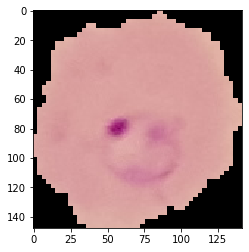

In [13]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'
para_img= imread(para_cell)
plt.imshow(para_img)

In [14]:
para_img.shape

(148, 142, 3)

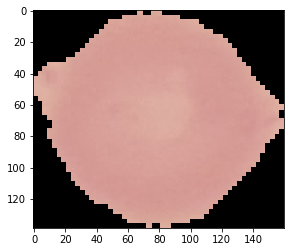

In [15]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

### Check the count of images

In [16]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [17]:
len(os.listdir(train_path+'\\uninfected'))

12480

### Check the average dimensions of these images.

In [18]:
unifected_cell.shape

(139, 160, 3)

In [19]:
para_img.shape

(148, 142, 3)

In [20]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

C:\Users\91970\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


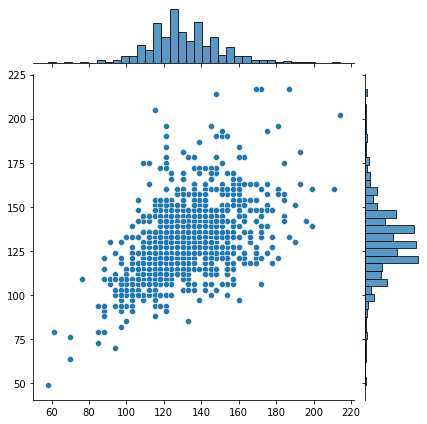

In [21]:
sns.jointplot(dim1,dim2)

In [22]:
np.mean(dim1)

130.92538461538462

In [23]:
np.mean(dim2)

130.75

In [24]:
image_shape = (130,130,3)

## Preparing the Data for the model

### Image Manipulation


#### Let us manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the ImageDataGenerator to do this 

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

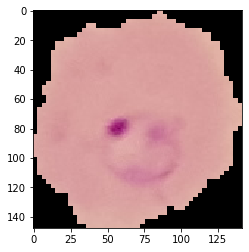

In [27]:
plt.imshow(para_img)

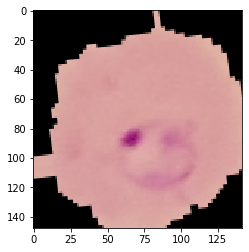

In [28]:
plt.imshow(image_gen.random_transform(para_img))

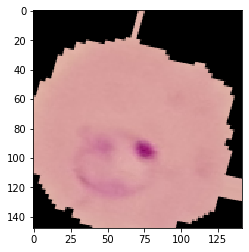

In [29]:
plt.imshow(image_gen.random_transform(para_img))

### Generating many manipulated images from a directory

#### In order to use .flow_from_directory, we must organize the images in sub-directories, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

In [31]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [32]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Creating the Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [34]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.

model.add(Dropout(0.5))

# Last layer is binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

### Early stopping

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:

early_stop = EarlyStopping(monitor='val_loss',patience=2)
### If there is negligable(very less) change in the validation loss for 2 successfull epochs then the model stops further execution

## Training the Model

In [38]:
batch_size = 16

In [39]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [40]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [41]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 504s 322ms/step - loss: 0.4070 - accuracy: 0.8201 - val_loss: 0.1909 - val_accuracy: 0.9346
Epoch 2/20
1560/1560 [==============================] - 453s 290ms/step - loss: 0.1816 - accuracy: 0.9423 - val_loss: 0.2043 - val_accuracy: 0.9319
Epoch 3/20
1560/1560 [==============================] - 386s 247ms/step - loss: 0.1711 - accuracy: 0.9472 - val_loss: 0.1643 - val_accuracy: 0.9465
Epoch 4/20
1560/1560 [==============================] - 387s 248ms/step - loss: 0.1689 - accuracy: 0.9485 - val_loss: 0.1709 - val_accuracy: 0.9458
Epoch 5/20
1560/1560 [==============================] - 389s 249ms/step - loss: 0.1611 - accuracy: 0.9492 - val_loss: 0.1502 - val_accuracy: 0.9527
Epoch 6/20
1560/1560 [==============================] - 389s 249ms/step - loss: 0.1580 - accuracy: 0.9520 - val_loss: 0.1671 - val_accuracy: 0.9465
Epoch 7/20
1560/1560 [==============================] - 389s 249ms/step - loss: 0.1574 - accuracy: 0.9500 - val_

In [44]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

### Evaluating the model

In [45]:
losses = pd.DataFrame(model.history.history)

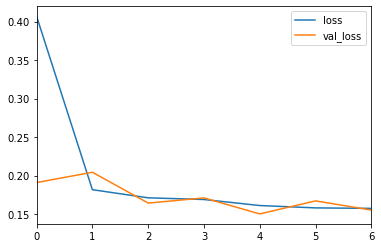

In [46]:
losses[['loss','val_loss']].plot()

In [47]:
model.metrics_names

['loss', 'accuracy']

In [48]:
model.evaluate_generator(test_image_gen)

[0.14778870344161987, 0.9519230723381042]

In [49]:
from tensorflow.keras.preprocessing import image

In [50]:
pred_probabilities = model.predict_generator(test_image_gen)

In [51]:
pred_probabilities

array([[5.1644444e-04],
       [4.5403838e-04],
       [1.0194480e-03],
       ...,
       [9.4170368e-01],
       [9.7110569e-01],
       [8.8959217e-01]], dtype=float32)

In [52]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [53]:
predictions = pred_probabilities > 0.5

In [54]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [55]:
from sklearn.metrics import classification_report,confusion_matrix

In [56]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1300
           1       0.93      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [57]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1209,   91],
       [  46, 1254]], dtype=int64)

### Predicting on an Image

In [58]:
para_cell

'C:/Users/91970/Capstone Project/DATA/cell_images/cell_images\\train\\\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [59]:
my_image = image.load_img(para_cell,target_size=image_shape)

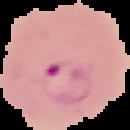

In [60]:
my_image

In [61]:
type(my_image)

PIL.Image.Image

In [62]:
my_image = image.img_to_array(my_image)

In [63]:
type(my_image)

numpy.ndarray

In [64]:
my_image.shape

(130, 130, 3)

In [65]:
my_image = np.expand_dims(my_image, axis=0)

In [66]:
my_image.shape

(1, 130, 130, 3)

In [67]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [68]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [69]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
##TO check Pull Requests and updates